Modules and libraries used 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from joblib import parallel_backend
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from joblib import parallel_backend
from functools import partial
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from joblib import parallel_backend, dump, load
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



Loading the given dataset 

In [2]:
Test_Dataset = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Dataset\GUIDE_Test.csv\GUIDE_Test.csv' # Training Dataset 
Train_Dataset = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Dataset\GUIDE_Train.csv\GUIDE_Train.csv' # Testing Dataset

In [ ]:
# Test_Dataset=r'Dataset\GUIDE_Test.csv'
# Train_Dataset=r'Dataset\GUIDE_Train.csv'

In [ ]:
import pandas as pd

# Load data in chunks to handle large file size
chunk_size = 500000  # Adjust chunk size for memory efficiency
chunks = []

# Reading the dataset in chunks
for chunk in pd.read_csv(Train_Dataset, chunksize=chunk_size, low_memory=False):
    # Optimize memory usage by downcasting data types
    for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)
del chunks  # Free up memory

# Display the first few rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# Display the shape of the dataset
print("\nShape of the dataset:", df.shape)

# Display the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Display the column names
print("Column Names in the Dataset:")
print(df.columns)

# Display data types and non-null counts of each column
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())


Data exploration 

Processing chunk 1...

Missing values in each column (First Chunk):
MitreTechniques      287358
IncidentGrade          2656
ActionGrouped        497090
ActionGranular       497090
EmailClusterId       494834
ThreatFamily         496080
ResourceType         499597
Roles                488662
AntispamDirection    490840
SuspicionLevel       424220
LastVerdict          382919
dtype: int64

Distribution of target variable 'IncidentGrade' (First Chunk):
IncidentGrade
BenignPositive    215445
TruePositive      174991
FalsePositive     106908
Name: count, dtype: int64


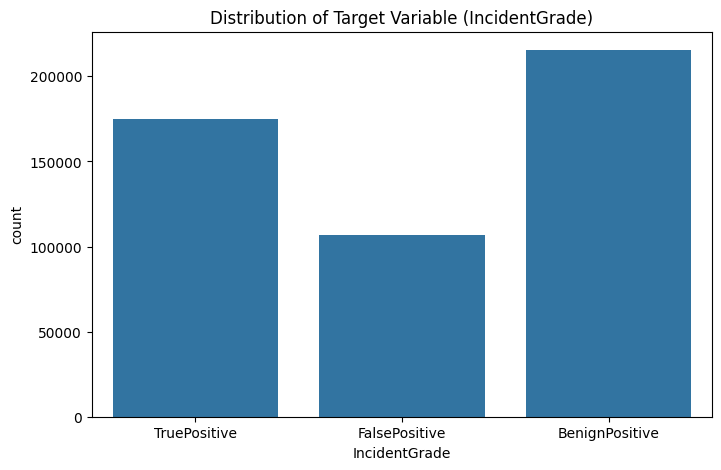

Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...

Combined Descriptive Statistics for Numeric Columns (averaged):
Id                    6.165253e+04
OrgId                 6.034231e+04
IncidentId            1.703026e+05
AlertId               4.969527e+05
DetectorId            6.073837e+04
AlertTitle            6.027770e+04
DeviceId              1.228830e+05
Sha256                1.489539e+05
IpAddress             2.931559e+05
Url                   1.631577e+05
AccountSid            3.450354e+05
AccountUpn            4.180538e+05
AccountObjectId       3.350238e+05
AccountName           3.524456e+05
DeviceName      

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File path for the dataset
file_path = Train_Dataset  
chunk_size = 500000  # Adjust based on system capacity

# Data type dictionary to optimize memory usage
dtype_dict = {
    'Id': 'int32', 'OrgId': 'int16', 'IncidentId': 'int32', 'AlertId': 'int32',
    'Timestamp': 'object', 'DetectorId': 'int16', 'AlertTitle': 'int16',
    'Category': 'object', 'MitreTechniques': 'object', 'IncidentGrade': 'object',
    'ActionGrouped': 'object', 'ActionGranular': 'object', 'EntityType': 'object',
    'EvidenceRole': 'object', 'DeviceId': 'int32', 'Sha256': 'int64',
    'IpAddress': 'int64', 'Url': 'int64', 'AccountSid': 'int32', 'AccountUpn': 'int32',
    'AccountObjectId': 'int32', 'AccountName': 'int32', 'DeviceName': 'int32',
    'NetworkMessageId': 'int32', 'EmailClusterId': 'float32', 'RegistryKey': 'int32',
    'RegistryValueName': 'int32', 'RegistryValueData': 'int32', 'ApplicationId': 'int32',
    'ApplicationName': 'int32', 'OAuthApplicationId': 'int32', 'ThreatFamily': 'object',
    'FileName': 'int32', 'FolderPath': 'int32', 'ResourceIdName': 'int32',
    'ResourceType': 'object', 'Roles': 'object', 'OSFamily': 'int16', 'OSVersion': 'int16',
    'AntispamDirection': 'object', 'SuspicionLevel': 'object', 'LastVerdict': 'object',
    'CountryCode': 'int16', 'State': 'int16', 'City': 'int32'
}

# Initialize accumulators for descriptive statistics, correlations, and outliers
desc_stats_accum = pd.DataFrame()
correlations_accum = pd.DataFrame()
outlier_counts = {}
total_outliers = 0

# Read data in chunks
chunks = pd.read_csv(file_path, chunksize=chunk_size, dtype=dtype_dict, low_memory=False)

# Process each chunk of data
for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i + 1}...")

    # Descriptive statistics for numeric columns in the current chunk
    numeric_columns = chunk.select_dtypes(include=['int32', 'int16', 'float32', 'int64'])
    desc_stats = numeric_columns.describe()

    # Accumulate descriptive statistics
    desc_stats_accum = pd.concat([desc_stats_accum, desc_stats])

    # Correlation matrix for numeric columns in the current chunk
    correlations = numeric_columns.corr()

    # Accumulate correlations
    correlations_accum = correlations_accum.add(correlations, fill_value=0)

    # Check for missing values (first chunk only)
    if i == 0:
        missing_values = chunk.isnull().sum()
        print("\nMissing values in each column (First Chunk):")
        print(missing_values[missing_values > 0])

        # Distribution of the target variable
        print("\nDistribution of target variable 'IncidentGrade' (First Chunk):")
        print(chunk['IncidentGrade'].value_counts())

        # Visualizing the target variable distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(x='IncidentGrade', data=chunk)
        plt.title('Distribution of Target Variable (IncidentGrade)')
        plt.show()

    # Detect outliers using the Interquartile Range (IQR) method
    for col in numeric_columns.columns:
        Q1 = chunk[col].quantile(0.25)
        Q3 = chunk[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = chunk[(chunk[col] < lower_bound) | (chunk[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_counts[col] = outlier_counts.get(col, 0) + outlier_count
        total_outliers += outlier_count

# Average the accumulated correlations
final_correlation_matrix = correlations_accum / (i + 1)

# Output combined descriptive statistics
print("\nCombined Descriptive Statistics for Numeric Columns (averaged):")
print(desc_stats_accum.mean())

# Output final correlation matrix
print("\nFinal Correlation Matrix for Numeric Columns (averaged):")
print(final_correlation_matrix)

# Print outlier counts for each numerical column
print("\nOutlier counts for each numerical column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

# Total number of outliers in the dataset
print(f"\nTotal number of outliers in the dataset: {total_outliers}")

# Concatenate all chunks for the entire dataset analysis
all_chunks = pd.read_csv(file_path, chunksize=chunk_size, dtype=dtype_dict, low_memory=False)
df = pd.concat(all_chunks, ignore_index=True)

# Check for duplicate rows in the entire dataset
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Display the first few rows of the dataset
print("\nFirst Few Rows of the Dataset:")
print(df.head())

# Display the shape of the dataset
print("\nShape of the dataset:", df.shape)

# Display the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Display the column names
print("\nColumn Names in the Dataset:")
print(df.columns)

# Display data types and non-null counts of each column
print("\nDataset Information:")
print(df.info())

# Check for missing values in the entire dataset
print("\nMissing values:")
print(df.isnull().sum())

# Target variable distribution for the entire dataset
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())


Processing chunk 1...

Missing values in each column (First Chunk):
MitreTechniques      277888
ActionGrouped        499746
ActionGranular       499746
EmailClusterId       494927
ThreatFamily         496223
ResourceType         499651
Roles                486823
AntispamDirection    490706
SuspicionLevel       421704
LastVerdict          380313
dtype: int64

Distribution of target variable 'IncidentGrade' (First Chunk):
IncidentGrade
BenignPositive    211593
TruePositive      180069
FalsePositive     108338
Name: count, dtype: int64


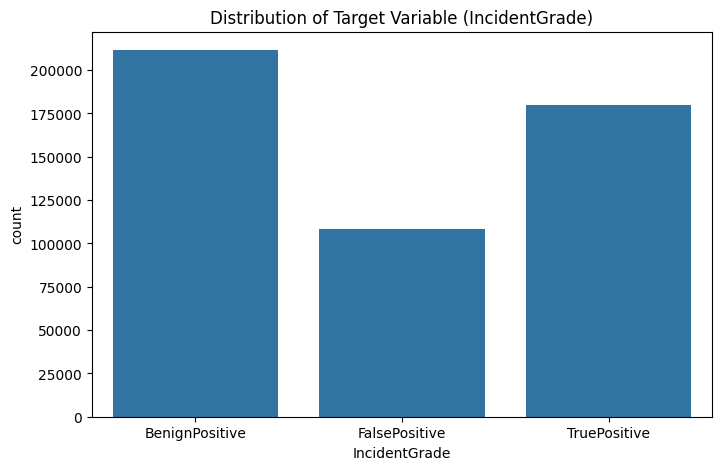

Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...

Combined Descriptive Statistics for Numeric Columns (averaged):
Id                    5.976503e+04
OrgId                 5.846353e+04
IncidentId            1.668710e+05
AlertId               4.952574e+05
DetectorId            5.886656e+04
AlertTitle            5.835896e+04
DeviceId              1.209987e+05
Sha256                1.471164e+05
IpAddress             2.913497e+05
Url                   1.612815e+05
AccountSid            3.432205e+05
AccountUpn            4.179454e+05
AccountObjectId       3.332295e+05
AccountName           3.507700e+05
DeviceName            1.567063e+05
NetworkMessageId      3.999728e+05
EmailClusterId        2.366076e+09
RegistryKey           5.863914e+04
RegistryValueName     5.800996e+04
RegistryValueData     5.815158e+04
ApplicationId         5.905303e+04
ApplicationName       5.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File path for the dataset
file_path = Test_Dataset
chunk_size = 500000  # Adjust based on system capacity

# Data loading with chunking and optimized data types
dtype_dict = {
    'Id': 'int32', 'OrgId': 'int16', 'IncidentId': 'int32', 'AlertId': 'int32',
    'Timestamp': 'object', 'DetectorId': 'int16', 'AlertTitle': 'int16',
    'Category': 'object', 'MitreTechniques': 'object', 'IncidentGrade': 'object',
    'ActionGrouped': 'object', 'ActionGranular': 'object', 'EntityType': 'object',
    'EvidenceRole': 'object', 'DeviceId': 'int32', 'Sha256': 'int64',
    'IpAddress': 'int64', 'Url': 'int64', 'AccountSid': 'int32', 'AccountUpn': 'int32',
    'AccountObjectId': 'int32', 'AccountName': 'int32', 'DeviceName': 'int32',
    'NetworkMessageId': 'int32', 'EmailClusterId': 'float32', 'RegistryKey': 'int32',
    'RegistryValueName': 'int32', 'RegistryValueData': 'int32', 'ApplicationId': 'int32',
    'ApplicationName': 'int32', 'OAuthApplicationId': 'int32', 'ThreatFamily': 'object',
    'FileName': 'int32', 'FolderPath': 'int32', 'ResourceIdName': 'int32',
    'ResourceType': 'object', 'Roles': 'object', 'OSFamily': 'int16', 'OSVersion': 'int16',
    'AntispamDirection': 'object', 'SuspicionLevel': 'object', 'LastVerdict': 'object',
    'CountryCode': 'int16', 'State': 'int16', 'City': 'int32', 'Usage' : 'object'
}

# Initialize accumulators for descriptive statistics, correlations, and outliers
desc_stats_accum = pd.DataFrame()
correlations_accum = pd.DataFrame()
outlier_counts = {}
total_outliers = 0

# Read data in chunks
chunks = pd.read_csv(file_path, chunksize=chunk_size, dtype=dtype_dict, low_memory=False)

# Process each chunk of data
for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i + 1}...")

    # Descriptive statistics for numeric columns in the current chunk
    numeric_columns = chunk.select_dtypes(include=['int32', 'int16', 'float32', 'int64'])
    desc_stats = numeric_columns.describe()

    # Accumulate descriptive statistics
    desc_stats_accum = pd.concat([desc_stats_accum, desc_stats])

    # Correlation matrix for numeric columns in the current chunk
    correlations = numeric_columns.corr()

    # Accumulate correlations
    correlations_accum = correlations_accum.add(correlations, fill_value=0)

    # Check for missing values (first chunk only)
    if i == 0:
        missing_values = chunk.isnull().sum()
        print("\nMissing values in each column (First Chunk):")
        print(missing_values[missing_values > 0])

        # Distribution of the target variable
        print("\nDistribution of target variable 'IncidentGrade' (First Chunk):")
        print(chunk['IncidentGrade'].value_counts())

        # Visualizing the target variable distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(x='IncidentGrade', data=chunk)
        plt.title('Distribution of Target Variable (IncidentGrade)')
        plt.show()

    # Detect outliers using the Interquartile Range (IQR) method
    for col in numeric_columns.columns:
        Q1 = chunk[col].quantile(0.25)
        Q3 = chunk[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = chunk[(chunk[col] < lower_bound) | (chunk[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_counts[col] = outlier_counts.get(col, 0) + outlier_count
        total_outliers += outlier_count

# Average the accumulated correlations
final_correlation_matrix = correlations_accum / (i + 1)

# Output combined descriptive statistics
print("\nCombined Descriptive Statistics for Numeric Columns (averaged):")
print(desc_stats_accum.mean())

# Output final correlation matrix
print("\nFinal Correlation Matrix for Numeric Columns (averaged):")
print(final_correlation_matrix)

# Print outlier counts for each numerical column
print("\nOutlier counts for each numerical column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

# Total number of outliers in the dataset
print(f"\nTotal number of outliers in the dataset: {total_outliers}")

# Concatenate all chunks for the entire dataset analysis
all_chunks = pd.read_csv(file_path, chunksize=chunk_size, dtype=dtype_dict, low_memory=False)
df = pd.concat(all_chunks, ignore_index=True)

# Check for duplicate rows in the entire dataset
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Display the first few rows of the dataset
print("\nFirst Few Rows of the Dataset:")
print(df.head())

# Display the shape of the dataset
print("\nShape of the dataset:", df.shape)

# Display the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Display the column names
print("\nColumn Names in the Dataset:")
print(df.columns)

# Display data types and non-null counts of each column
print("\nDataset Information:")
print(df.info())

# Check for missing values in the entire dataset
print("\nMissing values:")
print(df.isnull().sum())

# Target variable distribution for the entire dataset
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())


Pre processing 

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# File path and chunk size
file_path = Train_Dataset # Replace with the actual path to your dataset
chunk_size = 500000

# Data types dictionary to optimize memory usage
dtype_dict = {
    'Id': 'int32', 'OrgId': 'int16', 'IncidentId': 'int32', 'AlertId': 'int32',
    'Timestamp': 'object', 'DetectorId': 'int16', 'AlertTitle': 'int16',
    'Category': 'object', 'MitreTechniques': 'object', 'IncidentGrade': 'object',
    'ActionGrouped': 'object', 'ActionGranular': 'object', 'EntityType': 'object',
    'EvidenceRole': 'object', 'DeviceId': 'int32', 'Sha256': 'int64',
    'IpAddress': 'int64', 'Url': 'int64', 'AccountSid': 'int32', 'AccountUpn': 'int32',
    'AccountObjectId': 'int32', 'AccountName': 'int32', 'DeviceName': 'int32',
    'NetworkMessageId': 'int32', 'EmailClusterId': 'float32', 'RegistryKey': 'int32',
    'RegistryValueName': 'int32', 'RegistryValueData': 'int32', 'ApplicationId': 'int32',
    'ApplicationName': 'int32', 'OAuthApplicationId': 'int32', 'ThreatFamily': 'object',
    'FileName': 'int32', 'FolderPath': 'int32', 'ResourceIdName': 'int32',
    'ResourceType': 'object', 'Roles': 'object', 'OSFamily': 'int16', 'OSVersion': 'int16',
    'AntispamDirection': 'object', 'SuspicionLevel': 'object', 'LastVerdict': 'object',
    'CountryCode': 'int16', 'State': 'int16', 'City': 'int32'
}

# Read data in chunks and concatenate
chunks = pd.read_csv(file_path, chunksize=chunk_size, dtype=dtype_dict, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Drop columns with more than 80% missing values
threshold = 0.8
missing_percentages = df.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > threshold].index
df.drop(columns=columns_to_drop, inplace=True)

print(f"Columns dropped due to more than {threshold*100}% missing values: {columns_to_drop.tolist()}")

# Handling Missing Data
def impute_missing_values(df):
    # Impute numeric columns with median
    numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
    for col in numeric_columns:
        if df[col].isnull().any():
            median_val = df[col].median()
            print(f"Imputing column '{col}' with median value: {median_val}")
            df[col] = df[col].fillna(median_val)
    
    # Impute categorical columns with mode
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            print(f"Imputing column '{col}' with mode value: {mode_val}")
            df[col] = df[col].fillna(mode_val)
    
    return df

df = impute_missing_values(df)

# Handling Outliers
def remove_outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:  # Skip columns with too few unique values
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            before_count = df.shape[0]
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            after_count = df.shape[0]
            if before_count != after_count:
                print(f"Column '{col}' reduced from {before_count} to {after_count} rows after outlier removal.")
                if after_count == 0:
                    print(f"Warning: All values in column '{col}' were removed as outliers!")
    return df

df = remove_outliers(df, iqr_multiplier=3.0)  # More conservative IQR multiplier

# Feature Engineering: Extracting datetime features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour

# Drop the 'Timestamp' column
df.drop(columns=['Timestamp'], inplace=True)

# List of ID columns to exclude from scaling
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'CountryCode', 'State', 'City']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Check the min and max before scaling
print("\nBefore Scaling:")
print(numeric_features.describe())

# Scaling numerical features using MinMaxScaler
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Check the min and max after scaling
print("\nAfter Scaling:")
print(df[numeric_features.columns].describe())

# Encoding Categorical Variables using Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 
                       'SuspicionLevel', 'MitreTechniques', 'ThreatFamily', 
                       'ResourceType', 'Roles', 'AntispamDirection', 'LastVerdict']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

# Check for columns that are fully zero after preprocessing
zero_columns = [col for col in df.columns if (df[col].dtype in ['int32', 'int16', 'float32', 'int64']) and df[col].nunique() == 1 and df[col].unique()[0] == 0]

if zero_columns:
    print("\nColumns with all zeros after preprocessing:", zero_columns)
else:
    print("\nNo columns are completely zero.")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save processed data to CSV
df.to_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Training_data.csv', index=False)
print("Data preprocessing complete and saved to 'Training_data.csv'.")


Columns dropped due to more than 80.0% missing values: ['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel']
Imputing column 'MitreTechniques' with mode value: T1078;T1078.004
Imputing column 'IncidentGrade' with mode value: BenignPositive
Imputing column 'LastVerdict' with mode value: Suspicious
Column 'OrgId' reduced from 9516837 to 8842950 rows after outlier removal.
Column 'IncidentId' reduced from 8842950 to 8298653 rows after outlier removal.
Column 'DetectorId' reduced from 8298653 to 7455901 rows after outlier removal.
Column 'AlertTitle' reduced from 7455901 to 6306388 rows after outlier removal.
Column 'DeviceId' reduced from 6306388 to 6069978 rows after outlier removal.
Column 'Sha256' reduced from 6069978 to 5660450 rows after outlier removal.
Column 'IpAddress' reduced from 5660450 to 4126832 rows after outlier removal.
Column 'Url' reduced from 4126832 to 3534349 rows after outlier removal.
C

Preprocessing Testing Dataset 

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# File path and chunk size
file_path = Test_Dataset  # Ensure this is a valid path
chunk_size = 500000

# Data loading with chunking and optimized data types
dtype_dict = {
    'Id': 'int32', 'OrgId': 'int16', 'IncidentId': 'int32', 'AlertId': 'int32',
    'Timestamp': 'object', 'DetectorId': 'int16', 'AlertTitle': 'int16',
    'Category': 'object', 'MitreTechniques': 'object', 'IncidentGrade': 'object',
    'ActionGrouped': 'object', 'ActionGranular': 'object', 'EntityType': 'object',
    'EvidenceRole': 'object', 'DeviceId': 'int32', 'Sha256': 'int64',
    'IpAddress': 'int64', 'Url': 'int64', 'AccountSid': 'int32', 'AccountUpn': 'int32',
    'AccountObjectId': 'int32', 'AccountName': 'int32', 'DeviceName': 'int32',
    'NetworkMessageId': 'int32', 'EmailClusterId': 'float32', 'RegistryKey': 'int32',
    'RegistryValueName': 'int32', 'RegistryValueData': 'int32', 'ApplicationId': 'int32',
    'ApplicationName': 'int32', 'OAuthApplicationId': 'int32', 'ThreatFamily': 'object',
    'FileName': 'int32', 'FolderPath': 'int32', 'ResourceIdName': 'int32',
    'ResourceType': 'object', 'Roles': 'object', 'OSFamily': 'int16', 'OSVersion': 'int16',
    'AntispamDirection': 'object', 'SuspicionLevel': 'object', 'LastVerdict': 'object',
    'CountryCode': 'int16', 'State': 'int16', 'City': 'int32', 'Usage' : 'object'
}

# Read data in chunks and concatenate
chunks = pd.read_csv(file_path, chunksize=chunk_size, dtype=dtype_dict, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Drop columns with more than 80% missing values
threshold = 0.8
missing_percentages = df.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > threshold].index
df.drop(columns=columns_to_drop, inplace=True)

print(f"Columns dropped due to more than {threshold*100}% missing values: {columns_to_drop.tolist()}")

# Handling Missing Data
def impute_missing_values(df):
    # Impute numeric columns with median
    numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
    for col in numeric_columns:
        if df[col].isnull().any():
            median_val = df[col].median()
            print(f"Imputing column '{col}' with median value: {median_val}")
            df[col] = df[col].fillna(median_val)
    
    # Impute categorical columns with mode
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            print(f"Imputing column '{col}' with mode value: {mode_val}")
            df[col] = df[col].fillna(mode_val)
    
    return df

df = impute_missing_values(df)

# Handling Outliers
def remove_outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:  # Skip columns with too few unique values
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            before_count = df.shape[0]
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            after_count = df.shape[0]
            if before_count != after_count:
                print(f"Column '{col}' reduced from {before_count} to {after_count} rows after outlier removal.")
                if after_count == 0:
                    print(f"Warning: All values in column '{col}' were removed as outliers!")
    return df

df = remove_outliers(df, iqr_multiplier=3.0)  # More conservative IQR multiplier

# Feature Engineering: Extracting datetime features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour

# Drop the 'Timestamp' column
df.drop(columns=['Timestamp', 'Usage'], inplace=True) # Extra column "Usage" will affect the training in final Testing  

# List of ID columns to exclude from scaling
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'CountryCode', 'State', 'City']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Check the min and max before scaling
print("\nBefore Scaling:")
print(numeric_features.describe())

# Scaling numerical features using MinMaxScaler
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Check the min and max after scaling
print("\nAfter Scaling:")
print(df[numeric_features.columns].describe())

# Encoding Categorical Variables using Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 
                       'SuspicionLevel', 'MitreTechniques', 'ThreatFamily', 
                       'ResourceType', 'Roles', 'AntispamDirection', 'LastVerdict']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

# Check for columns that are fully zero after preprocessing
zero_columns = [col for col in df.columns if (df[col].dtype in ['int32', 'int16', 'float32', 'int64']) and df[col].nunique() == 1 and df[col].unique()[0] == 0]

if zero_columns:
    print("\nColumns with all zeros after preprocessing:", zero_columns)
else:
    print("\nNo columns are completely zero.")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save processed data to CSV
df.to_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Testing_data.csv', index=False)
print("Data preprocessing complete and saved to 'Testing_data.csv'.")


Columns dropped due to more than 80.0% missing values: ['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel']
Imputing column 'MitreTechniques' with mode value: T1078;T1078.004
Imputing column 'LastVerdict' with mode value: Suspicious
Column 'OrgId' reduced from 4147992 to 3880026 rows after outlier removal.
Column 'IncidentId' reduced from 3880026 to 3626027 rows after outlier removal.
Column 'DetectorId' reduced from 3626027 to 3239340 rows after outlier removal.
Column 'AlertTitle' reduced from 3239340 to 2787345 rows after outlier removal.
Column 'DeviceId' reduced from 2787345 to 2690484 rows after outlier removal.
Column 'Sha256' reduced from 2690484 to 2507111 rows after outlier removal.
Column 'IpAddress' reduced from 2507111 to 1851199 rows after outlier removal.
Column 'Url' reduced from 1851199 to 1602488 rows after outlier removal.
Column 'AccountSid' reduced from 1602488 to 921596 rows after out

Data Splitting 

In [8]:
import pandas as pd

# Load data in chunks to handle large file size
chunk_size = 500000  # Adjust chunk size for memory efficiency
chunks = []

# Reading the dataset in chunks
for chunk in pd.read_csv(Train_Dataset, chunksize=chunk_size, low_memory=False):
    # Optimize memory usage by downcasting data types
    for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)
del chunks  # Free up memory

# Display the first few rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# Display the shape of the dataset
print("\nShape of the dataset:", df.shape)

# Display the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Display the column names
print("Column Names in the Dataset:")
print(df.columns)

# Display data types and non-null counts of each column
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution for the entire dataset
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())




First Few Rows of the Dataset:
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0   180388628218      0         612   123247  2024-06-04T06:05:15.000Z   
1   455266534868     88         326   210035  2024-06-14T03:01:25.000Z   
2  1056561957389    809       58352   712507  2024-06-13T04:52:55.000Z   
3  1279900258736     92       32992   774301  2024-06-10T16:39:36.000Z   
4   214748368522    148        4359   188041  2024-06-15T01:08:07.000Z   

   DetectorId  AlertTitle           Category MitreTechniques   IncidentGrade  \
0           7           6      InitialAccess             NaN    TruePositive   
1          58          43       Exfiltration             NaN   FalsePositive   
2         423         298      InitialAccess           T1189   FalsePositive   
3           2           2  CommandAndControl             NaN  BenignPositive   
4           9          74          Execution             NaN    TruePositive   

   ... ResourceType Roles OSFamily OSVersio

Data splitting with Stratified sampling 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Training_data.csv')

# Specify your target variable
target_variable = 'IncidentGrade'  # Change this to your target variable column name

# Define the stratified sampling size (10% of the dataset)
sampling_size = 0.10

# Optionally, sample 10% of the dataset if needed
if sampling_size > 0:
    df = df.sample(frac=sampling_size, random_state=42)

# Perform the train-validation split with stratification
X = df.drop(columns=[target_variable])  # Features
y = df[target_variable]  # Target

# Split the dataset into training and validation sets with 80-20 split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.20,  # 80% train, 20% validation
    stratify=y,      # Stratify based on the target variable
    random_state=42  # For reproducibility
)

# Optional: Convert to DataFrames if needed
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)

# Save the splits to CSV files (optional)
train_df.to_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv', index=False)
valid_df.to_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv', index=False)

print("Train and validation splits created successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")


Train and validation splits created successfully.
Training set shape: (67608, 39)
Validation set shape: (16903, 39)


Model Selection and Training

Logistic Regression

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time
import psutil
import os

# Load stratified sampled data
train_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv'
valid_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv'

# Read the datasets
df_train = pd.read_csv(train_file_path)
df_valid = pd.read_csv(valid_file_path)

# Prepare features and target variable
X_train = df_train.drop(columns=['IncidentGrade'])
y_train = df_train['IncidentGrade']
X_valid = df_valid.drop(columns=['IncidentGrade'])
y_valid = df_valid['IncidentGrade']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Initialize logistic regression
logreg = LogisticRegression(solver='liblinear')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' is required for l1 penalty
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Train model with time tracking
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

# Get the best model
best_logreg = grid_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_pred = best_logreg.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      1745
           1       0.78      0.61      0.69      1995
           2       0.92      0.95      0.94     13163

    accuracy                           0.88     16903
   macro avg       0.77      0.72      0.74     16903
weighted avg       0.87      0.88      0.87     16903

Confusion Matrix:
[[ 1063   187   495]
 [  218  1226   551]
 [  504   154 12505]]
Training Time: 204.12 seconds
Memory Usage: 537.91 MB


Decision Tree Model 

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
import time
import psutil
import os

# Load stratified sampled data
train_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv'
valid_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv'

# Read the datasets
df_train = pd.read_csv(train_file_path)
df_valid = pd.read_csv(valid_file_path)

# Prepare features and target variable
X_train = df_train.drop(columns=['IncidentGrade'])
y_train = df_train['IncidentGrade']
X_valid = df_valid.drop(columns=['IncidentGrade'])
y_valid = df_valid['IncidentGrade']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Initialize decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_dist, 
                                    n_iter=50, scoring='accuracy', cv=5, n_jobs=-1, verbose=1, random_state=42)

# Train model with time tracking
start_time = time.time()
random_search.fit(X_train_scaled, y_train)
end_time = time.time()

# Get the best model
best_decision_tree = random_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_pred = best_decision_tree.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Python\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constr

Best Parameters:
{'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6}

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1745
           1       0.87      0.86      0.86      1995
           2       0.98      0.97      0.97     13163

    accuracy                           0.94     16903
   macro avg       0.86      0.87      0.87     16903
weighted avg       0.94      0.94      0.94     16903

Confusion Matrix:
[[ 1384   160   201]
 [  158  1712   125]
 [  309   106 12748]]
Training Time: 14.33 seconds
Memory Usage: 518.64 MB


 Random Forest Model

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
import time
import psutil
import os

# Load prepared data
X_train = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Setup randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Train model with randomized search and time tracking
start_time = time.time()

# Use joblib for parallel processing
with parallel_backend('loky'):
    random_search.fit(X_train, y_train)

end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate the model on the validation data
y_pred = best_rf.predict(X_val)

# Print results
print(f"Best Hyperparameters: {random_search.best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1745
           1       0.94      0.93      0.94      1995
           2       0.99      0.99      0.99     13163

    accuracy                           0.98     16903
   macro avg       0.95      0.96      0.96     16903
weighted avg       0.98      0.98      0.98     16903

Confusion Matrix:
[[ 1653    64    28]
 [   69  1861    65]
 [   57    51 13055]]
Training Time: 2150.80 seconds
Memory Usage: 191.07 MB


Gradient Boosting Machines - XGBoost 

In [19]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
import time
import psutil
import os
from functools import partial

# Load prepared data
X_train = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define optimized parameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 6, 9],           # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],     # Fraction of samples used for fitting each base learner
    'colsample_bytree': [0.7, 0.8, 1.0] # Fraction of features used for each tree
}

# Create a custom fit method with early stopping
fit_with_early_stopping = partial(
    xgb_model.fit,
    early_stopping_rounds=10,
    eval_set=[(X_val, y_val)],
    verbose=0
)

xgb_model.fit = fit_with_early_stopping

# Setup randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of parameter settings to sample
    cv=cv, 
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1, 
    random_state=42
)

# Train model with randomized search and time tracking
start_time = time.time()

# Use joblib for parallel processing
with parallel_backend('loky'):
    random_search.fit(X_train, y_train)

end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_xgb = random_search.best_estimator_

# Evaluate the model on validation data
y_pred = best_xgb.predict(X_val)

# Print results
print(f"Best Hyperparameters: {random_search.best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


c:\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1745
           1       0.94      0.93      0.94      1995
           2       0.99      0.99      0.99     13163

    accuracy                           0.98     16903
   macro avg       0.95      0.95      0.95     16903
weighted avg       0.98      0.98      0.98     16903

Confusion Matrix:
[[ 1644    62    39]
 [   76  1853    66]
 [   61    53 13049]]
Training Time: 228.99 seconds
Memory Usage: 254.43 MB


Gradient Boosting Machines - LightGBM

In [24]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
import time
import psutil
import os

# Load prepared data
# Load prepared data
X_train = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')


# Initialize LightGBM classifier
lgbm = LGBMClassifier()

# Define parameter grid for random search
param_dist = {
    'n_estimators': [100, 200, 300],          # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],       # Step size shrinkage
    'num_leaves': [31, 50, 70],                # Maximum number of leaves in one tree
    'max_depth': [-1, 10, 20],                 # Maximum depth of a tree (-1 means no limit)
    'subsample': [0.7, 0.8, 1.0],             # Fraction of samples used for fitting each base learner
    'colsample_bytree': [0.7, 0.8, 1.0]       # Fraction of features used for each tree
}

# Setup random search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,
    random_state=42
)

# Train model with random search and time tracking
start_time = time.time()
with parallel_backend('loky'):
    random_search.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_lgbm = random_search.best_estimator_

# Evaluate the model on validation data
y_pred = best_lgbm.predict(X_val)

# Print results
print(f"Best Hyperparameters: {random_search.best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 67608, number of used features: 16
[LightGBM] [Info] Start training from score -2.270821
[LightGBM] [Info] Start training from score -2.136913
[LightGBM] [Info] Start training from score -0.250060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Neural Network

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import psutil
import os

# Load prepared data
X_train = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv')
y_train = X_train.pop('IncidentGrade')  # Remove 'IncidentGrade' from X_train and assign it to y_train
X_val = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')  # Remove 'IncidentGrade' from X_val and assign it to y_val

# One-hot encoding if needed
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values

# Initialize a neural network for multiclass classification
def create_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax activation for multiclass classification

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
num_classes = y_train.shape[1]
model = create_model(X_train.shape[1], num_classes)

# Set up early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)

# Train the model with early stopping and time tracking
start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Start with fewer epochs
    batch_size=32,  # Smaller batch size for quicker updates
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)
y_val_classes = y_val.argmax(axis=-1)

# Print results
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_val_classes, y_pred_classes))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Epoch 1/50


c:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2113/2113 - 9s - 4ms/step - accuracy: 0.8310 - loss: 0.4813 - val_accuracy: 0.8701 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 2/50
2113/2113 - 5s - 2ms/step - accuracy: 0.8598 - loss: 0.3666 - val_accuracy: 0.3609 - val_loss: 1.0578 - learning_rate: 0.0010
Epoch 3/50
2113/2113 - 4s - 2ms/step - accuracy: 0.8634 - loss: 0.3517 - val_accuracy: 0.8778 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 4/50
2113/2113 - 4s - 2ms/step - accuracy: 0.8670 - loss: 0.3371 - val_accuracy: 0.8812 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 5/50
2113/2113 - 4s - 2ms/step - accuracy: 0.8700 - loss: 0.3334 - val_accuracy: 0.8505 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 6/50
2113/2113 - 4s - 2ms/step - accuracy: 0.8713 - loss: 0.3265 - val_accuracy: 0.8464 - val_loss: 0.3650 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2113/2113 - 4s - 2ms/step - accuracy: 0.8734 - loss: 0.3232 - val_accuracy: 0.8023 - val_loss: 0.6546

 Model Evaluation and Tuning 

Comparison on Advanced Models

Comparison Table:
         Model  Accuracy  Macro-F1 Score  Precision (Macro)  Recall (Macro)  Training Time (s)  Memory Usage (MB)
 Random Forest      0.98            0.96               0.95            0.96            2150.80             191.07
       XGBoost      0.98            0.95               0.95            0.95             228.99             254.43
      LightGBM      0.98            0.96               0.96            0.95             123.95             212.55
Neural Network      0.88            0.76               0.75            0.76              39.06             475.77

Best Model Based on Macro-F1 Score:
Model                Random Forest
Accuracy                      0.98
Macro-F1 Score                0.96
Precision (Macro)             0.95
Recall (Macro)                0.96
Training Time (s)           2150.8
Memory Usage (MB)           191.07
Name: 0, dtype: object


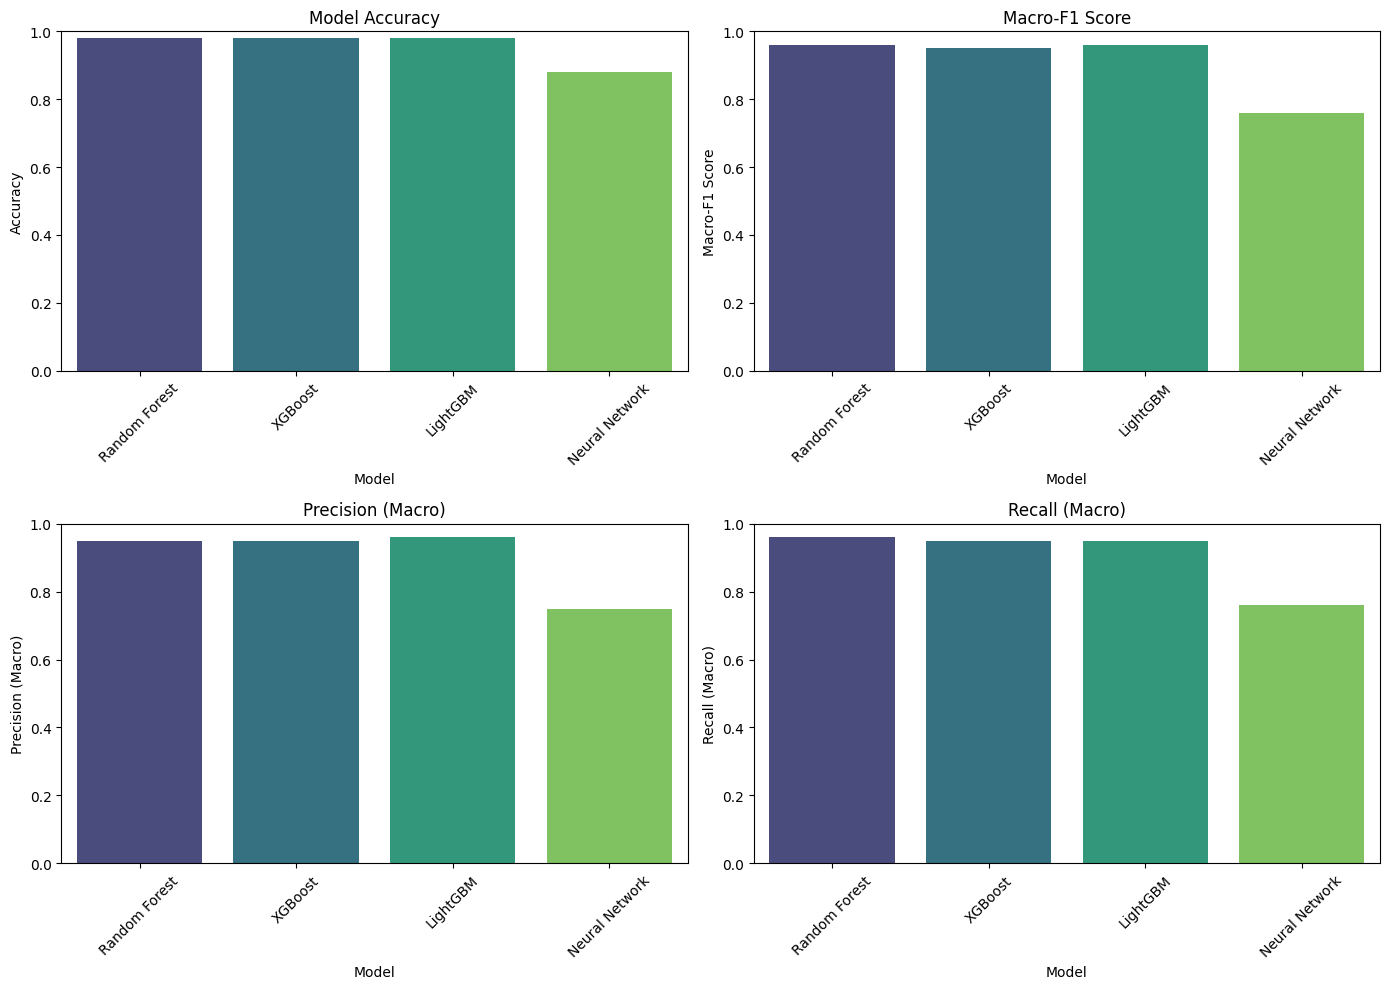

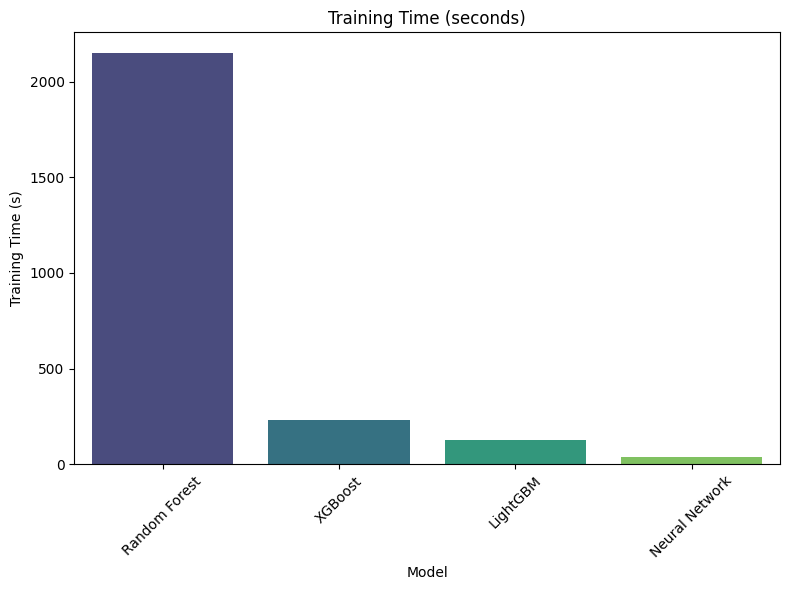

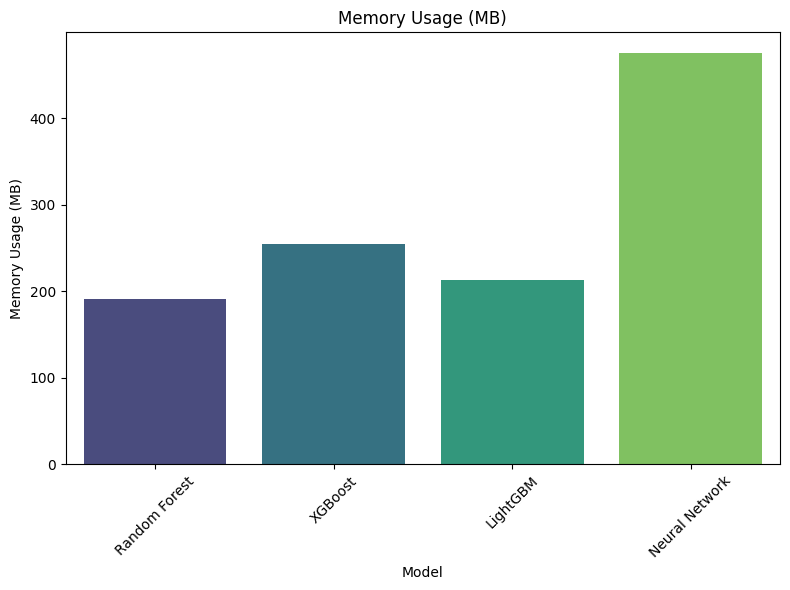

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for comparison based on your provided outputs
data = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
    'Accuracy': [0.98,0.98,0.98,0.88],
    'Macro-F1 Score': [0.96,0.95,0.96,0.76],
    'Precision (Macro)': [0.95,0.95,0.96,0.75],
    'Recall (Macro)': [0.96,0.95,0.95,0.76],
    'Training Time (s)': [2150.80,228.99,123.95,39.06],
    'Memory Usage (MB)': [191.07,254.43,212.55,475.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

# Set the figure size
plt.figure(figsize=(14, 10))

# Plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Macro-F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Macro-F1 Score', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Macro-F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Precision (Macro)
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Precision (Macro)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Precision (Macro)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Recall (Macro)
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Recall (Macro)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Recall (Macro)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()
plt.show()

# Plot for Training Time
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Training Time (s)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Memory Usage
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Memory Usage (MB)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Memory Usage (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Summary of Metrics

Here's how each metric is relevant:

a. Accuracy: Overall correctness of the model.

b. Macro-F1 Score: Average F1 score across all classes, treating each class equally.

c. Precision (Macro): Average precision score across all classes.

d. Recall (Macro): Average recall score across all classes.

e. Training Time: Time taken to train the model.

f. Memory Usage: Amount of memory used by the model.

The best model based on Macro-F1 Score is selected as it ensures the model's balanced performance across all classes, making it more suitable for situations where each class's performance is critical.

2) Selected Advanced Model - Random Forest with Hyperparameter Tuning and Class Imbalance Handling

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend, dump
import time
import psutil
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [3]:

# Load prepared data
X_train = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv')
y_train = X_train.pop('IncidentGrade')  
X_val = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')  


# Initialize SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2', None, 0.5, 0.75],  # Number of features to consider for the best split
    'min_samples_split': [2, 5, 10, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Setup randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Create pipeline with SMOTE and RandomizedSearchCV
pipeline = Pipeline([
    ('smote', smote),
    ('random_search', random_search)
])

# Train model with randomized search and time tracking
start_time = time.time()
with parallel_backend('loky'):
    pipeline.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_rf = pipeline.named_steps['random_search'].best_estimator_

# Evaluate the model on the validation data
y_pred = best_rf.predict(X_val)

# Print results
print(f"Best Hyperparameters: {pipeline.named_steps['random_search'].best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Save the best model as a .pkl file
dump(best_rf, r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\model12.pkl')
print("Model saved as model12.pkl")


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.75, 'max_depth': 50, 'bootstrap': False}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1745
           1       0.91      0.91      0.91      1995
           2       0.99      0.98      0.99     13163

    accuracy                           0.96     16903
   macro avg       0.91      0.94      0.92     16903
weighted avg       0.97      0.96      0.97     16903

Confusion Matrix:
[[ 1607   107    31]
 [  126  1823    46]
 [  204    78 12881]]
Training Time: 19836.53 seconds
Memory Usage: 260.33 MB
Model saved as model12.pkl


F. Model Interpretation

Feature Importance and Error Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from joblib import load

Calculating Random Forest Built-in Feature Importance...
Top 10 Important Features:
            Feature  Importance
2        IncidentId    0.320536
1             OrgId    0.152161
7   MitreTechniques    0.151296
3           AlertId    0.078216
8        EntityType    0.063272
0                Id    0.053198
31      LastVerdict    0.038049
6          Category    0.032059
37        DayOfWeek    0.024922
5        AlertTitle    0.024594


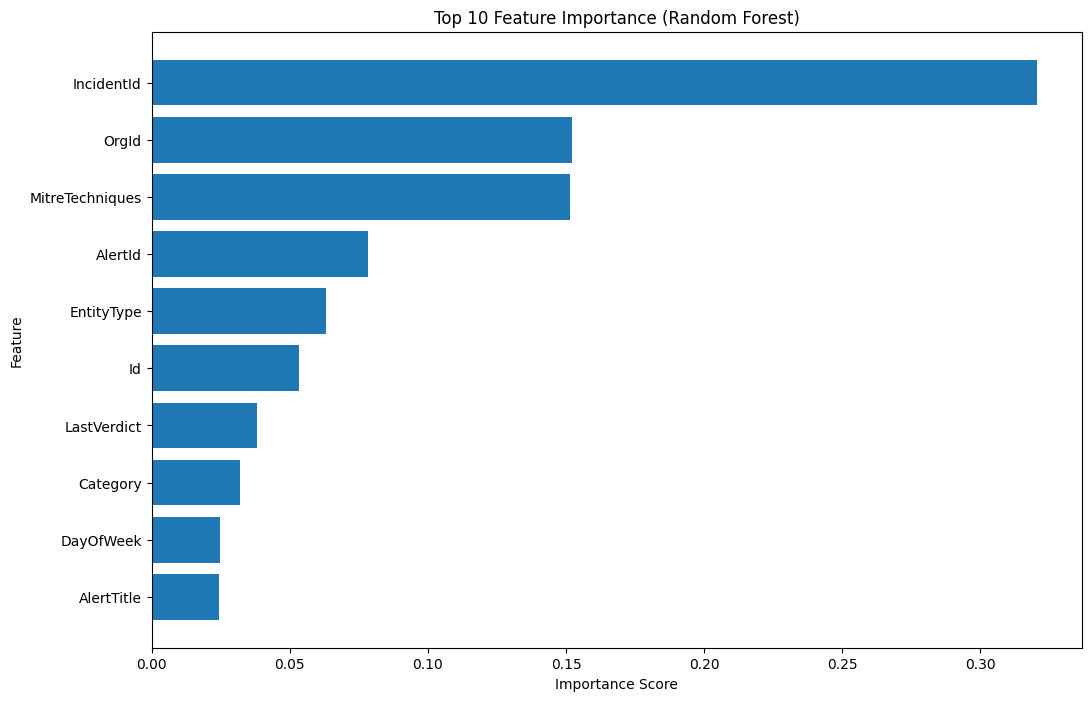

Number of misclassifications: 592
Sample misclassified cases:
       Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  Category  \
15   3864     68        1333     8940          35    0.388817         6   
16   3803    606       41345   115512           6    0.365410         6   
47   3570    247       37784   216694           1    0.360208         6   
65     81     67      180627   242825          10    0.369311         6   
105  3529    136      177775  1319621           7    0.366710         6   

     MitreTechniques  EntityType  EvidenceRole  ...  OSFamily  OSVersion  \
15                27           8             0  ...       0.0        0.0   
16                27           6             1  ...       0.0        0.0   
47                29           6             1  ...       0.0        0.0   
65                28           6             1  ...       0.0        0.0   
105               23           0             1  ...       0.0        0.0   

     LastVerdict  CountryCode 

In [5]:


# Load prepared data
X_train = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Train_split.csv')
y_train = X_train.pop('IncidentGrade')  
X_val = pd.read_csv(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Valid_split.csv')
y_val = X_val.pop('IncidentGrade')  

# Load the trained Random Forest model
best_rf = load(r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\model12.pkl')

# Calculate feature importance
print("Calculating Random Forest Built-in Feature Importance...")
feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print("Top 10 Important Features:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Make predictions
y_pred = best_rf.predict(X_val)

# Error Analysis
misclassified_indices = np.where(y_pred != y_val)[0]
num_misclassified = len(misclassified_indices)
print(f"Number of misclassifications: {num_misclassified}")

# Display sample of misclassified cases
print("Sample misclassified cases:")
print(X_val.iloc[misclassified_indices].head())

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


G. Final Evaluation on Test Set

In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from joblib import load
import time
import psutil
import os

In [7]:

# Load the saved model
best_model_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\model12.pkl'
loaded_model = load(best_model_path)

# Load the test dataset
test_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Testing_data.csv'
df_test = pd.read_csv(test_file_path)

# Prepare test data
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Start time for evaluating the model
start_time = time.time()

# Make predictions using the loaded model
y_test_pred = loaded_model.predict(X_test)

# End time for evaluating the model
end_time = time.time()

# Calculate memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Calculate and print the evaluation metrics
print("Test Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Print training time and memory usage
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Test Set Results:
Macro-F1 Score: 0.8631
Macro Precision: 0.8353
Macro Recall: 0.8975

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.88      0.79     36643
           1       0.81      0.86      0.83     42156
           2       0.99      0.95      0.97    313840

    accuracy                           0.94    392639
   macro avg       0.84      0.90      0.86    392639
weighted avg       0.94      0.94      0.94    392639

Confusion Matrix (Test Set):
[[ 32150   3093   1400]
 [  4221  36314   1621]
 [  8851   5701 299288]]
Evaluation Time: 3.83 seconds
Memory Usage: 815.31 MB


2) Baseline model - Logestic regression on Test Data

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time
import psutil
import os


In [9]:


# Load the test dataset
test_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Testing_data.csv'
df_test = pd.read_csv(test_file_path)

# Prepare features and target variable
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Initialize logistic regression with default parameters
logreg = LogisticRegression(max_iter=100, solver='liblinear')

# Train-validation split with stratification
# Split the data again for training and validation since it's mentioned as 'Test Dataset'
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Train model with time tracking
start_time = time.time()
logreg.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the model on validation data (using the test split as validation here)
y_val_pred = logreg.predict(X_val)

# Print validation results
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Calculate and print the evaluation metrics for the validation set
print("\nValidation Set Results:")
print(f"Macro-F1 Score: {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_val, y_val_pred, average='macro'):.4f}")

# Evaluate the model on the entire test data (use this if you want to evaluate on the full test set)
y_test_pred = logreg.predict(X_test)

# Calculate and print the evaluation metrics for the test set
print("\nTest Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      7329
           1       0.72      0.57      0.64      8431
           2       0.90      0.96      0.93     62768

    accuracy                           0.86     78528
   macro avg       0.72      0.62      0.66     78528
weighted avg       0.84      0.86      0.85     78528

Validation Confusion Matrix:
[[ 2366  1072  3891]
 [  601  4834  2996]
 [ 1472   816 60480]]
Training Time: 19.26 seconds
Memory Usage: 929.86 MB

Validation Set Results:
Macro-F1 Score: 0.6565
Macro Precision: 0.7166
Macro Recall: 0.6199

Test Set Results:
Macro-F1 Score: 0.6534
Macro Precision: 0.7137
Macro Recall: 0.6167

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40     36643
           1       0.71      0.57      0.63     42156
           2       0.90      0.96      0.93    313840

    accu

Baseline model - Decision Tree on Test Data

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time
import psutil
import os
import numpy as np


In [11]:


# Load the test dataset
test_file_path = r'C:\Users\hbhat\OneDrive\Desktop\VScode\Capstone4\Testing_data.csv'
df_test = pd.read_csv(test_file_path)

# Prepare features and target variable
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Initialize decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'ccp_alpha': np.linspace(0, 0.02, 10)  # Pruning parameter
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train model with time tracking
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best model
best_decision_tree = grid_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_val_pred = best_decision_tree.predict(X_val)

# Print validation results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Evaluate the best model on the entire test data
y_test_pred = best_decision_tree.predict(X_test)

# Calculate and print the evaluation metrics for the test set
print("\nTest Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
Best Parameters:
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7329
           1       0.97      0.97      0.97      8431
           2       1.00      1.00      1.00     62768

    accuracy                           0.99     78528
   macro avg       0.98      0.98      0.98     78528
weighted avg       0.99      0.99      0.99     78528

Validation Confusion Matrix:
[[ 7100   140    89]
 [  150  8159   122]
 [   96   150 62522]]
Training Time: 4952.44 seconds
Memory Usage: 433.42 MB

Test Set Results:
Macro-F1 Score: 0.9954
Macro Precision: 0.9952
Macro Recall: 0.9955

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     36643
           1    

Comparison of Base line Models with Advanced model 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Comparison of Model Performance:
                 Model  Accuracy  Macro Avg Precision  Macro Avg Recall  \
0        Random Forest      0.94               0.8353            0.8975   
1  Logistic Regression      0.86               0.7137            0.6167   
2        Decision Tree      1.00               0.9952            0.9955   

   Macro Avg F1-Score  Weighted Avg Precision  Weighted Avg Recall  \
0              0.8631                    0.94                 0.94   
1              0.6534                    0.84                 0.86   
2              0.9954                    1.00                 1.00   

   Weighted Avg F1-Score  Training Time (s)  Memory Usage (MB)  \
0                   0.94               3.83             815.31   
1                   0.85              19.26             929.86   
2                   1.00            4952.44             433.42   

   Time per Accuracy (s)  Memory per Accuracy (MB)  
0               4.074468                867.351064  
1             

C:\Users\hbhat\AppData\Local\Temp\ipykernel_14636\2894361831.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df, ax=axes[0, 0], palette="viridis")
C:\Users\hbhat\AppData\Local\Temp\ipykernel_14636\2894361831.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Macro Avg F1-Score', data=df, ax=axes[0, 1], palette="viridis")
C:\Users\hbhat\AppData\Local\Temp\ipykernel_14636\2894361831.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Weighted Avg Precision', data=df, ax=axes[1, 

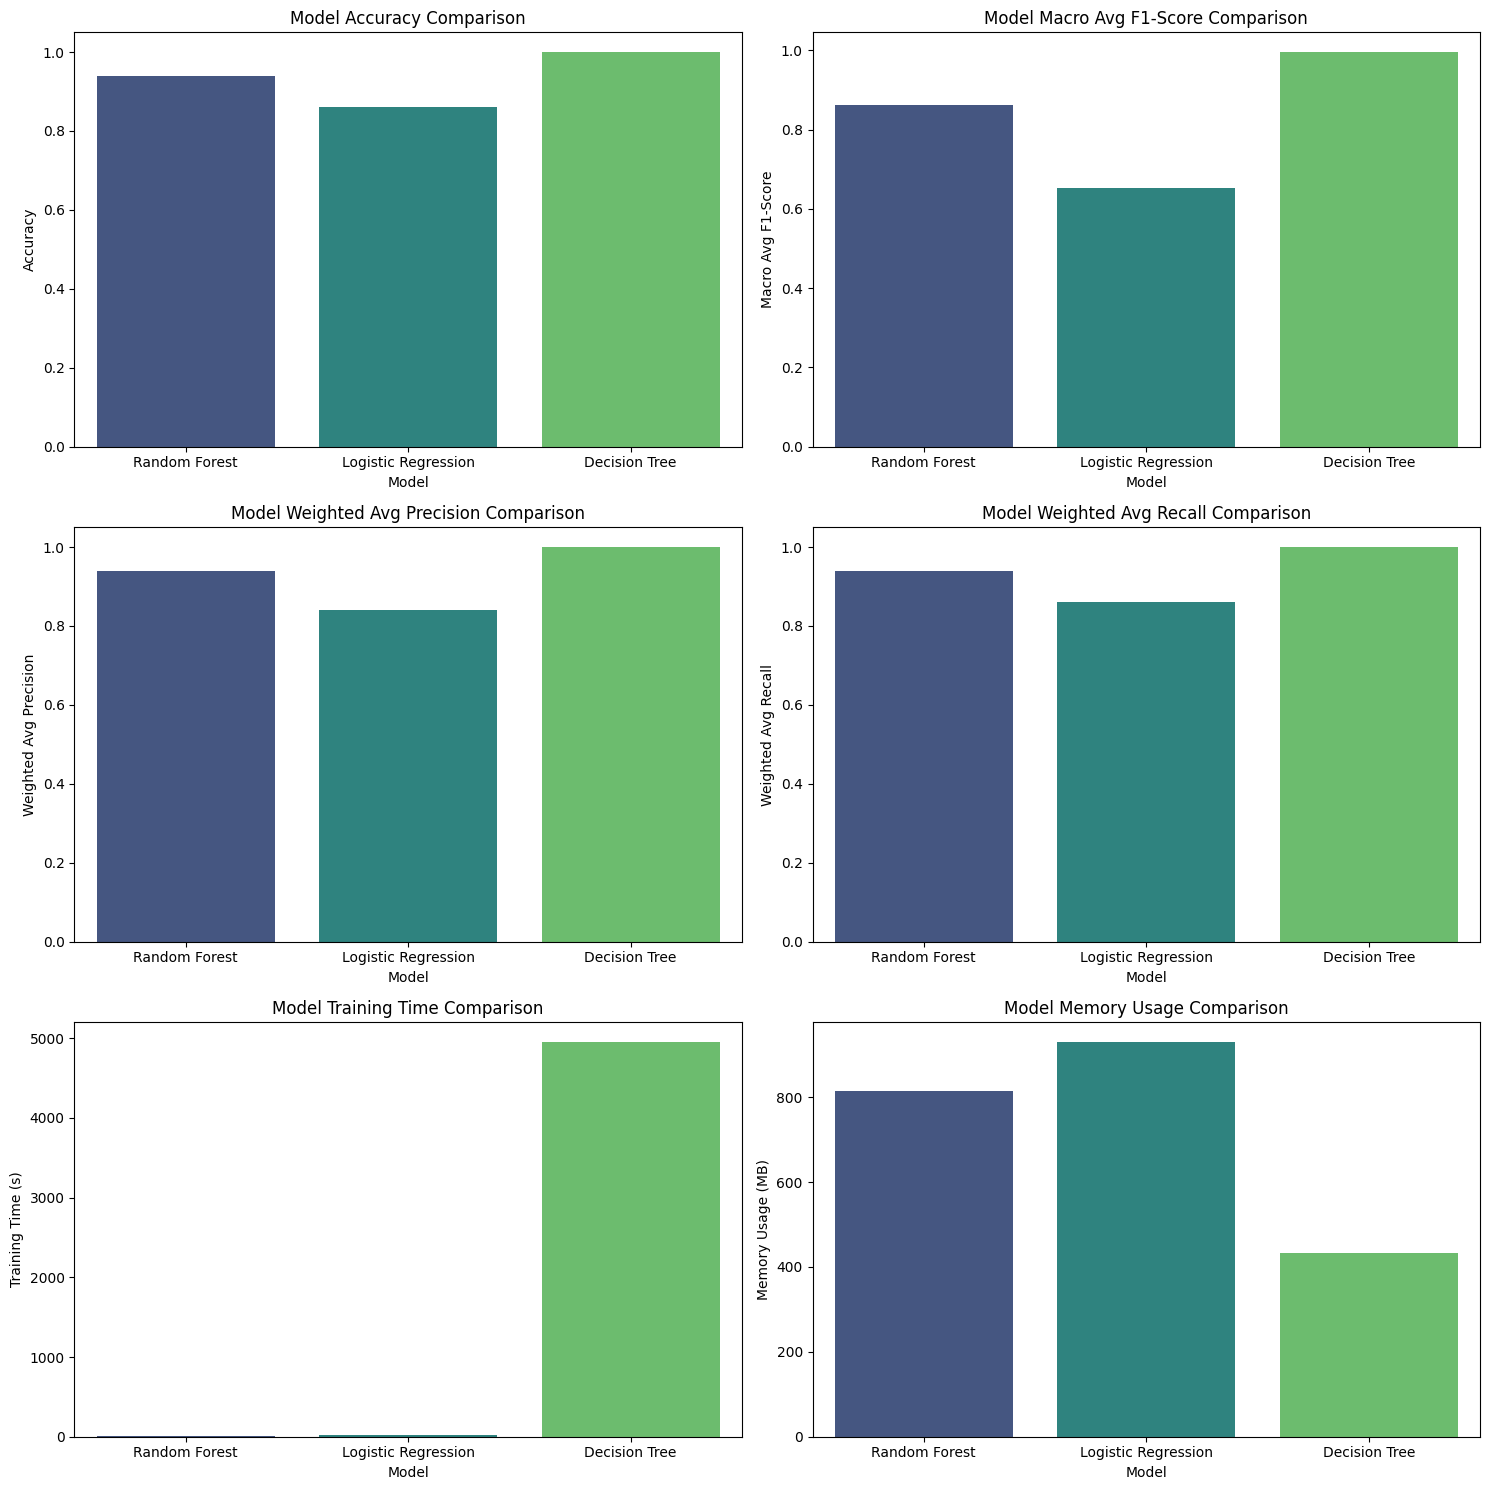

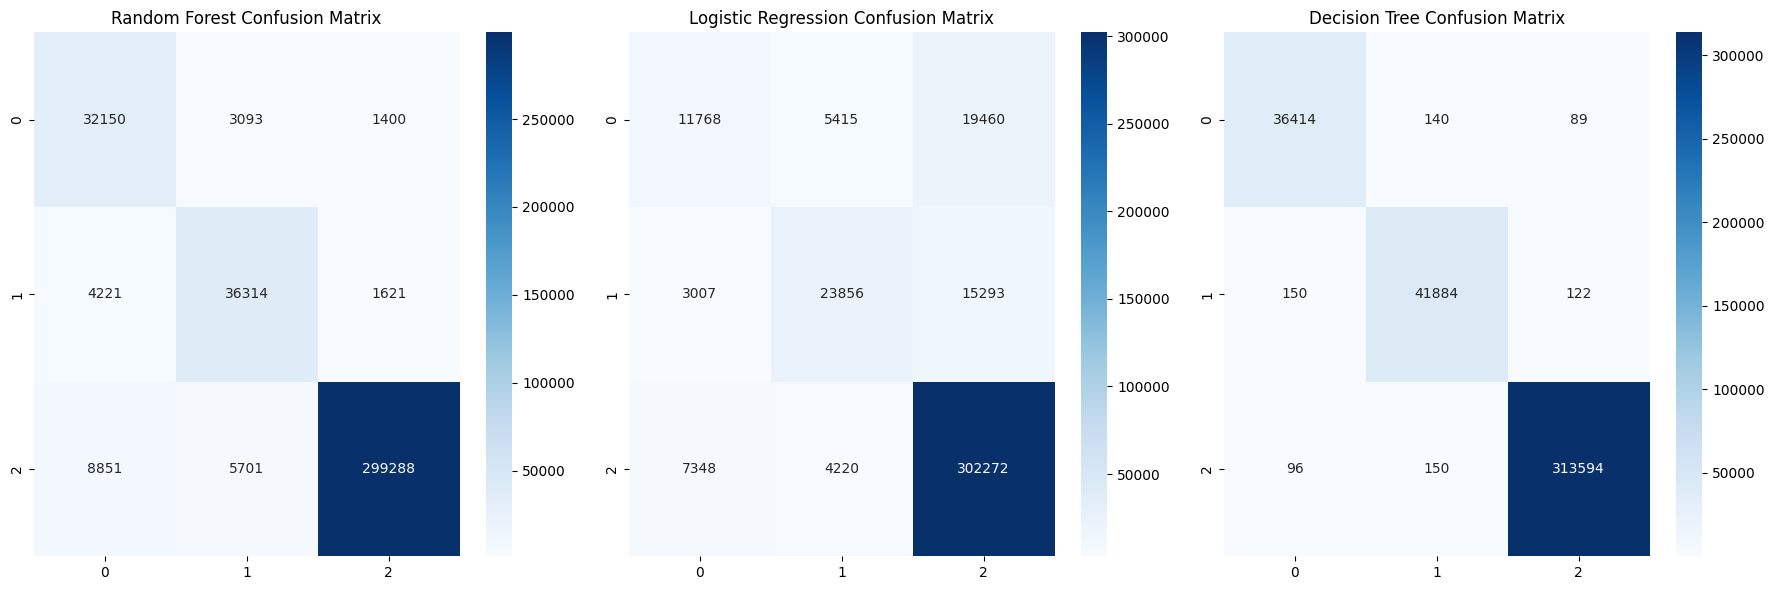

C:\Users\hbhat\AppData\Local\Temp\ipykernel_14636\2894361831.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Time per Accuracy (s)', data=df, ax=axes[0], palette="viridis")
C:\Users\hbhat\AppData\Local\Temp\ipykernel_14636\2894361831.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Memory per Accuracy (MB)', data=df, ax=axes[1], palette="viridis")


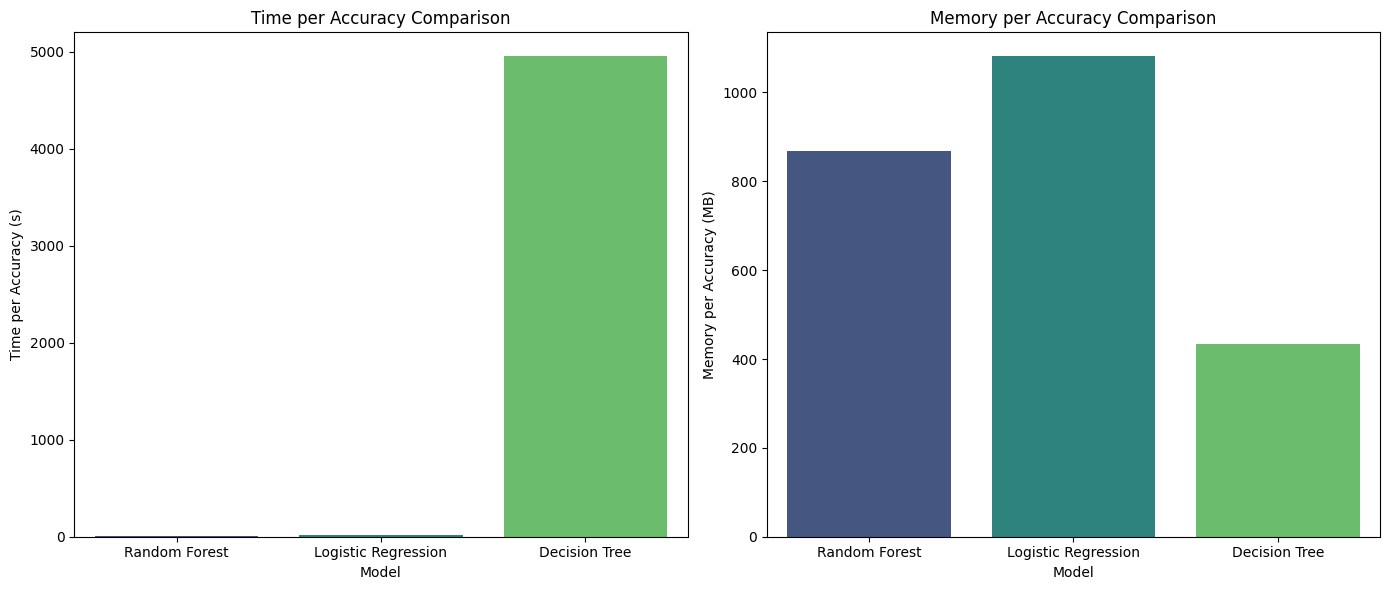

In [2]:

# Random Forest results as dictionaries
random_forest_report = {
    "accuracy": 0.94,
    "macro avg": {"precision": 0.8353, "recall": 0.8975, "f1-score": 0.8631},
    "weighted avg": {"precision": 0.94, "recall": 0.94, "f1-score": 0.94},
    "Training Time (s)": 3.83,
    "Memory Usage (MB)": 815.31,
    "Confusion Matrix": np.array([[32150, 3093, 1400], [4221, 36314, 1621], [8851, 5701, 299288]])
}

# Logistic Regression results as dictionaries
logistic_regression_report = {
    "accuracy": 0.86,
    "macro avg": {"precision": 0.7137, "recall": 0.6167, "f1-score": 0.6534},
    "weighted avg": {"precision": 0.84, "recall": 0.86, "f1-score": 0.85},
    "Training Time (s)": 19.26,
    "Memory Usage (MB)": 929.86,
    "Confusion Matrix": np.array([[11768, 5415, 19460], [3007, 23856, 15293], [7348, 4220, 302272]])
}


# Decision Tree results as dictionaries
decision_tree_report = {
    "accuracy": 1.00,
    "macro avg": {"precision": 0.9952, "recall": 0.9955, "f1-score": 0.9954},
    "weighted avg": {"precision": 1.00, "recall": 1.00, "f1-score": 1.00},
    "Training Time (s)": 4952.44,
    "Memory Usage (MB)": 433.42,
    "Confusion Matrix": np.array([[36414, 140, 89], [150, 41884, 122], [96, 150, 313594]])
}

# Creating a DataFrame for better visualization
data = {
    "Model": ["Random Forest", "Logistic Regression", "Decision Tree"],
    "Accuracy": [random_forest_report["accuracy"], logistic_regression_report["accuracy"], decision_tree_report["accuracy"]],
    "Macro Avg Precision": [random_forest_report["macro avg"]["precision"], logistic_regression_report["macro avg"]["precision"], decision_tree_report["macro avg"]["precision"]],
    "Macro Avg Recall": [random_forest_report["macro avg"]["recall"], logistic_regression_report["macro avg"]["recall"], decision_tree_report["macro avg"]["recall"]],
    "Macro Avg F1-Score": [random_forest_report["macro avg"]["f1-score"], logistic_regression_report["macro avg"]["f1-score"], decision_tree_report["macro avg"]["f1-score"]],
    "Weighted Avg Precision": [random_forest_report["weighted avg"]["precision"], logistic_regression_report["weighted avg"]["precision"], decision_tree_report["weighted avg"]["precision"]],
    "Weighted Avg Recall": [random_forest_report["weighted avg"]["recall"], logistic_regression_report["weighted avg"]["recall"], decision_tree_report["weighted avg"]["recall"]],
    "Weighted Avg F1-Score": [random_forest_report["weighted avg"]["f1-score"], logistic_regression_report["weighted avg"]["f1-score"], decision_tree_report["weighted avg"]["f1-score"]],
    "Training Time (s)": [random_forest_report["Training Time (s)"], logistic_regression_report["Training Time (s)"], decision_tree_report["Training Time (s)"]],
    "Memory Usage (MB)": [random_forest_report["Memory Usage (MB)"], logistic_regression_report["Memory Usage (MB)"], decision_tree_report["Memory Usage (MB)"]],
    "Time per Accuracy (s)": [random_forest_report["Training Time (s)"]/random_forest_report["accuracy"], logistic_regression_report["Training Time (s)"]/logistic_regression_report["accuracy"], decision_tree_report["Training Time (s)"]/decision_tree_report["accuracy"]],
    "Memory per Accuracy (MB)": [random_forest_report["Memory Usage (MB)"]/random_forest_report["accuracy"], logistic_regression_report["Memory Usage (MB)"]/logistic_regression_report["accuracy"], decision_tree_report["Memory Usage (MB)"]/decision_tree_report["accuracy"]]
}

df = pd.DataFrame(data)

# Print the DataFrame to compare
print("Comparison of Model Performance:")
print(df)

# Visualization using matplotlib and seaborn

# Create subplots for each metric category
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Accuracy
sns.barplot(x='Model', y='Accuracy', data=df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Model Accuracy Comparison')

# Macro Avg F1-Score
sns.barplot(x='Model', y='Macro Avg F1-Score', data=df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Model Macro Avg F1-Score Comparison')

# Weighted Avg Precision
sns.barplot(x='Model', y='Weighted Avg Precision', data=df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Model Weighted Avg Precision Comparison')

# Weighted Avg Recall
sns.barplot(x='Model', y='Weighted Avg Recall', data=df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Model Weighted Avg Recall Comparison')

# Training Time
sns.barplot(x='Model', y='Training Time (s)', data=df, ax=axes[2, 0], palette="viridis")
axes[2, 0].set_title('Model Training Time Comparison')

# Memory Usage
sns.barplot(x='Model', y='Memory Usage (MB)', data=df, ax=axes[2, 1], palette="viridis")
axes[2, 1].set_title('Model Memory Usage Comparison')

plt.tight_layout()
plt.show()

# Confusion Matrix Heatmaps
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(random_forest_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Random Forest Confusion Matrix')

sns.heatmap(logistic_regression_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(decision_tree_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Decision Tree Confusion Matrix')

plt.tight_layout()
plt.show()

# Additional Comparison of Time and Memory per Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='Time per Accuracy (s)', data=df, ax=axes[0], palette="viridis")
axes[0].set_title('Time per Accuracy Comparison')

sns.barplot(x='Model', y='Memory per Accuracy (MB)', data=df, ax=axes[1], palette="viridis")
axes[1].set_title('Memory per Accuracy Comparison')

plt.tight_layout()
plt.show()
